In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import statsmodels.api as sm
import statsmodels.tsa.stattools as smt # for ccf 
from statsmodels.stats.diagnostic import compare_j # J-test
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Useful functions

In [2]:
def get_shortest_array(a,b):
    '''
    input - a,b arrays (pandas.values) arrays
    output - returns length of shortest array using first index of np.shape
    '''
    
    len_a = np.shape(a)[0]
    len_b = np.shape(b)[0]
    
    return min(len_a,len_b)

In [3]:
def plot_cor_old(x, y, window, filename, x_name, y_name):
    '''
    x (df) - first time series
    y (df) - second time series
    window (int) - period length
    filename - output filename as .png
    x_name - first time series name (for title)
    y_name - second time series name (for title)
    Note that x and y don't have to be the same length. the 'get_shortest_array' function will be used to automatically trim the time series
    '''
    shortest_time_series_len = get_shortest_array(x,y)
    plt.plot(x.iloc[:shortest_time_series_len].dropna().rolling(window).corr(y.iloc[:shortest_time_series_len].dropna()));
    
    # rotate x-axis labels so date labels all fit in properly
    plt.xticks(rotation=90);
    plt.title('20-day rolling correlation between '+str(x_name)+ ' and '+str(y_name))
    plt.savefig(str(filename),dpi=600)


In [4]:
def plot_cor(x, y, window, filename, x_name, y_name):
    '''
    x (df) - first time series
    y (df) - second time series
    window (int) - period length
    filename - output filename as .png
    x_name - first time series name (for title)
    y_name - second time series name (for title)
    Note that x and y don't have to be the same length. the 'get_shortest_array' function will be used to automatically trim the time series
    '''
    shortest_time_series_len = get_shortest_array(x,y)
    plt.plot(x.iloc[:shortest_time_series_len].rolling(window).corr(y.iloc[:shortest_time_series_len]).fillna(method='bfill'));
    
    # rotate x-axis labels so date labels all fit in properly
    plt.xticks(rotation=90);
    plt.title('20-day rolling correlation between '+str(x_name)+ ' and '+str(y_name))
    plt.savefig(str(filename),dpi=600)


# Import data

In [5]:
HK50 = pd.read_csv('data/HS/HK50.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCC = pd.read_csv('data/HS/HSCC.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCE = pd.read_csv('data/HS/HSCE.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIC = pd.read_csv('data/HS/HSCIC.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCICD = pd.read_csv('data/HS/HSCICD.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCICS = pd.read_csv('data/HS/HSCICS.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIE = pd.read_csv('data/HS/HSCIE.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIF = pd.read_csv('data/HS/HSCIF.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIH = pd.read_csv('data/HS/HSCIH.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIIG = pd.read_csv('data/HS/HSCIIG.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIIT = pd.read_csv('data/HS/HSCIIT.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIM = pd.read_csv('data/HS/HSCIM.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIPC = pd.read_csv('data/HS/HSCIPC.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIT = pd.read_csv('data/HS/HSCIT.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIU = pd.read_csv('data/HS/HSCIU.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')

In [6]:
# create a dataframe containing HSI, first put the above into a dictionary for easy iteration

HSI_dict = {"HSCC": HSCC,
            "HSCE": HSCE,
            "HSCIC": HSCIC,
            "HSCICD": HSCICD,
            "HSCICS": HSCICS,
            "HSCIE": HSCIE,
            "HSCIE": HSCIE,
            "HSCIF": HSCIF,
            "HSCIH": HSCIH,
            "HSCIIG": HSCIIG,
            "HSCIIT": HSCIIT,
            "HSCIM": HSCIM,
            "HSCIPC": HSCIPC,
            "HSCIT": HSCIT,
            "HSCIU": HSCIU}

HSI_df = pd.DataFrame()

for ind in HSI_dict.keys():
    HSI_df = pd.concat([HSI_df, HSI_dict[ind]['Price']], axis=1)
    
HSI_df.columns = HSI_dict.keys()

In [7]:
# calculate sector index returns

HSI_returns_df =  np.log(HSI_df.dropna()) - np.log(HSI_df.dropna().shift(-1))
HK50['Return'] = np.log(HK50['Price']) - np.log(HK50['Price'].shift(-1))
HK50 = HK50.dropna()

# make sure to convert HSI dictionary to datetime, otherwise sklearn can break.
HSI_returns_df.index = pd.to_datetime(HSI_returns_df.index)

# Results

## Index descriptive stats

In [136]:
HK50_mean = str(round(HK50['Return'].mean()*100.,5))+'%'
HK50_sdev = str(round(HK50['Return'].std()*100.,5))+'%'
HK50_count = HK50['Return'].size

# print
print("The mean, standard dev and count of HK50 returns are: "+str(HK50_mean)+' '+str(HK50_sdev)+' '+str(HK50_count))

The mean, standard dev and count of HK50 returns are: 0.00273% 1.27972% 2829


In [137]:
# to import into libreoffice calc, ctrl-shift-v then paste unformatted. Convert text-to-columns.

for elem in HSI_returns_df.keys():
    mean = str(round(HSI_returns_df[elem].mean()*100.,5))+'%'
    sdev = str(round(HSI_returns_df[elem].std()*100.,5))+'%'
    count = HSI_returns_df[elem].size
    print("The mean, standard dev and count of "+str(elem)+" returns are: "+str(mean)+' '+str(sdev)+' '+str(count))

The mean, standard dev and count of HSCC returns are: -0.00867% 1.51073% 831
The mean, standard dev and count of HSCE returns are: -0.04452% 1.75764% 831
The mean, standard dev and count of HSCIC returns are: -0.03606% 1.46476% 831
The mean, standard dev and count of HSCICD returns are: 0.01509% 2.05191% 831
The mean, standard dev and count of HSCICS returns are: -0.00733% 1.56298% 831
The mean, standard dev and count of HSCIE returns are: 0.0057% 1.93187% 831
The mean, standard dev and count of HSCIF returns are: -0.01107% 1.38513% 831
The mean, standard dev and count of HSCIH returns are: -0.00482% 2.57401% 831
The mean, standard dev and count of HSCIIG returns are: -0.00198% 1.8395% 831
The mean, standard dev and count of HSCIIT returns are: 0.01012% 2.73956% 831
The mean, standard dev and count of HSCIM returns are: 0.05045% 2.34094% 831
The mean, standard dev and count of HSCIPC returns are: -0.05771% 1.71762% 831
The mean, standard dev and count of HSCIT returns are: -0.02795% 1.

## Sector index correlation

In [36]:
HSI_returns_df.keys()

for elem in HSI_returns_df.keys():
    filename = "HK50_"+str(elem)+"_20corr.png"
    x_name = "HK50"
    y_name = str(elem)
    plot_cor(HK50['Return'], HSI_returns_df[elem], 20, filename, x_name, y_name)
    plt.close()


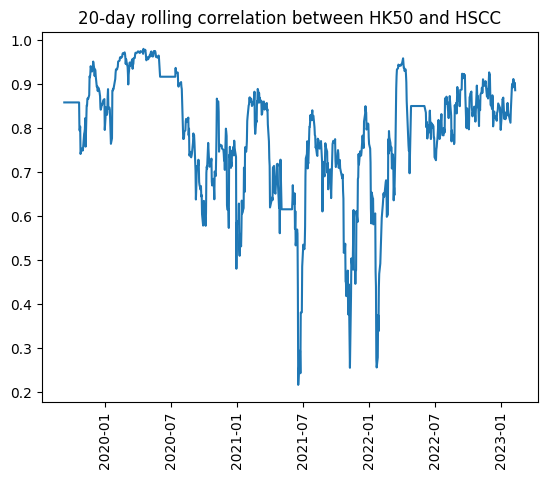

In [32]:
# (test code) same code as cell below but using function

plot_cor(HK50['Return'], HSI_returns_df['HSCC'], 20, "HK50_HSCC_20corr.png", "HK50", "HSCC")

## Using J-test

In [18]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import compare_j # J-test
from sklearn.preprocessing import StandardScaler

# need to worry about consistent dates / indices selection. See also below where y is reindexed relative to X. 
X = HSI_returns_df[['HSCC',"HSCE"]]["2019-09-10":"2023-02-08"].fillna(method='ffill')
y = HK50['Return']["2019-09-10":"2023-02-08"].fillna(method='ffill')
y = y.reindex(X.index)


# another modification to our original code with Sklearn, I've added a column of ones so a constant term
# is added to our regression model. This is done using the sm.add_constant keyword. 
X = sm.add_constant(X)
X = StandardScaler().fit_transform(X)
# regression_leading_test = sm.OLS(y.reindex(X.index), X).fit() 
regression_leading_test = sm.OLS(y, X).fit() 

In [19]:
regression_leading_test

In [37]:
# get jtest statistic and pvalue for all sector indices vs HK50

sector_models_OLS = {}

for elem in HSI_returns_df:
    X = HSI_returns_df[elem]["2019-09-10":"2023-02-08"].fillna(method='ffill')
    y = HK50['Return']["2019-09-10":"2023-02-08"].fillna(method='ffill')
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    sector_models_OLS[elem] = sm.OLS(y, X).fit() 

In [16]:
# indexing two columns of a dataframe at once
# HSI_returns_df[['HSCC',"HSCE"]]["2019-09-10":"2023-02-08"].fillna(method='ffill')

,HSCC,HSCE
2023-02-08,0.010649,-0.005958
2023-02-07,0.003958,0.005947
2023-02-06,-0.013832,-0.027121
2023-02-03,-0.013061,-0.015950
2023-02-02,-0.009237,-0.007249
...,...,...
2019-09-16,0.005239,-0.005583
2019-09-13,0.007474,0.008964
2019-09-12,0.000133,0.002586
2019-09-11,0.008655,0.015421


In [12]:
sector_models_OLS

{'HSCC': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f89bef20340>,
 'HSCE': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f89659dc0d0>,
 'HSCIC': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8964c35870>,
 'HSCICD': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8964c34c40>,
 'HSCICS': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f89659deb90>,
 'HSCIE': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8964c359c0>,
 'HSCIF': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8964c35540>,
 'HSCIH': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8964c35e40>,
 'HSCIIG': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8964c36260>,
 'HSCIIT': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f8964c364d0>,
 'HSCIM': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7

In [13]:
compare_j(sector_models_OLS["HSCC"],sector_models_OLS["HSCE"])

(42.35699441470146, 1.159089247826358e-209)

In [27]:
from itertools import combinations

sample_list = HSI_returns_df.columns
list_combinations = []

list_combinations += list(combinations(sample_list,2))
    

When attempting to do this for pairwise linear models in sector_models_OLS, we run into the non-nested models error. Maybe I'll just compare models using AIC for now?  

In [42]:
results = {}

for elem in list_combinations:
    #print(elem)
    print(elem)
    first_HK_index = elem[0]
    second_HK_index = elem[1]
    results[elem] = compare_j(sector_models_OLS[first_HK_index],sector_models_OLS[second_HK_index])
    
results = pd.DataFrame(results,index=list_combinations,columns=['J-test statistic', 'J-test p-value'])

('HSCC', 'HSCE')


ValueError: The exog in results_x and in results_z are nested. J comparison requires that models are non-nested.


Using AIC. A temporary workaround. 

In [51]:
for elem in sector_models_OLS.keys():
    print('Exogenous variable: '+str(elem)+'. AIC: '+str(sector_models_OLS[elem].aic))    

Exogenous variable: HSCC. AIC: -5508.840606042309
Exogenous variable: HSCE. AIC: -6981.254427624647
Exogenous variable: HSCIC. AIC: -5092.97099972019
Exogenous variable: HSCICD. AIC: -5804.331111364424
Exogenous variable: HSCICS. AIC: -5341.118629786088
Exogenous variable: HSCIE. AIC: -4897.926140770197
Exogenous variable: HSCIF. AIC: -5713.816416206997
Exogenous variable: HSCIH. AIC: -5200.258431404865
Exogenous variable: HSCIIG. AIC: -5412.532846567192
Exogenous variable: HSCIIT. AIC: -5637.347920023066
Exogenous variable: HSCIM. AIC: -5047.48666635554
Exogenous variable: HSCIPC. AIC: -5347.644738762612
Exogenous variable: HSCIT. AIC: -4863.261455107681
Exogenous variable: HSCIU. AIC: -5009.363502536354


In [ ]:
# working code
jtest_statistic = {}
jtest_pvalue = {}

for etf in _11_SPDR_ETFs:
    jtest_pvalue[etf] = np.zeros((3,3))
    jtest_statistic[etf] = np.zeros((3,3))

    regression_results_list = [regression_leading[etf],regression_coinc[etf],regression_lagging[etf]]

    for i in range(len(regression_results_list)):
        for j in range(len(regression_results_list)):
            if j != i:
                jtest_statistic[etf][i][j], jtest_pvalue[etf][i][j] =\
                compare_j(regression_results_list[i],regression_results_list[j])

    # finally, convert all dictionaries to pandas dataframes to make things more readable
    jtest_pvalue[etf] = pd.DataFrame(jtest_pvalue[etf],index=['H0','H1','H2'],columns=['H0','H1','H2'])
    jtest_statistic[etf] = pd.DataFrame(jtest_statistic[etf],index=['H0','H1','H2'],columns=['H0','H1','H2'])

### Attempt to do this for all combinations of sector indices vs HK50. These are nested models

Having trouble indexing by tuple. See here: https://stackoverflow.com/questions/43347939/all-possible-combinations-of-columns-in-dataframe-pandas-python

In [ ]:
from itertools import combinations

sample_list = HSI_returns_df.columns
list_combinations = []

for n in range(len(sample_list)+1):
    list_combinations += list(combinations(sample_list,n))
    

## Determine lags

In [ ]:
    '''
    shortest_time_series_len = get_shortest_array(x,y)
    plt.plot(x.iloc[:shortest_time_series_len].dropna().rolling(window).corr(y.iloc[:shortest_time_series_len].dropna()));

In [66]:
x = HK50['Return']
y = HSI_returns_df['HSCC']

shortest_time_series_len = get_shortest_array(x,y)

x = x.iloc[:shortest_time_series_len]
y = y.iloc[:shortest_time_series_len]

test_correlation = signal.correlate(x, y, mode="full")
test_lags = signal.correlation_lags(x.size, y.size, mode="full")
test_lag = test_lags[np.argmax(test_correlation)]

In [69]:
test_correlation

array([            nan,             nan,             nan, ...,
        9.11327954e-06, -9.12429017e-05, -1.33982510e-05])

In [ ]:


rng = np.random.default_rng()
x = rng.standard_normal(1000)
y = np.concatenate([rng.standard_normal(100), x])
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]